# Deep Neural Network (DNN) 

### Regularization of DNN [256,256,256,256] with dropout

##  Get the data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time

%store -r
%store

Stored variables and their in-db values:
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.7957011
X_32train_std             -> array([[-0.44445615,  0.62874736, -0.19049071, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[-0.004097
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ 0.8784659
X_train                   -> array([[[-0.00304779,  0.0030504 , -0.00249425, ..
X_train_std               -> array([[-0.44445615,  0.62874736, -0.19049071, ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_32_test                 -> defaultdict(<class 'list'>, {0: array([6, 7, 1, ..
y_32_train                -> array([7, 2, 4, ..., 5, 5, 3])
y_test                    -> defaultdict(<class 'list'>, {0: array([3, 2, 5, ..
y_train                   -> array([7, 2, 4, ..., 5, 5, 3])


In [2]:
print("Training data: ", X_32train_std.shape, "and labels: ", y_32_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_32test_std), X_32test_std[18].shape, "arrays for SNR values:")
print(sorted(X_32test_std.keys()))

Training data:  (80000, 32) and labels:  (80000,)
 
Test data:
Total 20 (4000, 32) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [3]:
# tf.reset_default_graph()

## Create validation set required for early stopping

In [4]:
X_val = []
y_val = []

X_test_new = defaultdict(list)
y_test_new = defaultdict(list)

for snr in snrs:
    n_test = X_32test_std[snr].shape[0]
    X_val.append(X_32test_std[snr][:(n_test*0.5)])
    y_val.append(y_32_test[snr][:(n_test*0.5)])
    X_test_new[snr] = X_32test_std[snr][(n_test*0.5):]
    y_test_new[snr] = y_32_test[snr][(n_test*0.5):]
    
X_val = np.vstack(np.asarray(X_val))
y_val =np.hstack(np.asarray(y_val))

print("Validation set data", X_val.shape, "and labels", y_val.shape)

X_32test_std = X_test_new
y_32_test = y_test_new
X_32_val = X_val 
y_32_val = y_val

Validation set data (40000, 32) and labels (40000,)


##  Design and train the DNN

In [7]:
# ----------------- Initialize parameters -----------------------


n_hidden1 = 256
n_hidden2 = 256
n_hidden3 = 256
n_hidden4 = 256

drop_rate = 0.25
n_outputs = 8

dropout_rate = 0.25

X = tf.placeholder(tf.float32, shape=(None, 32))
y = tf.placeholder(tf.int64, shape=(None))
training_ = tf.placeholder_with_default(False, shape=[])

# ------------------- Define layers -----------------------

from tensorflow.contrib.layers import fully_connected

def layer(X, n_neurons, activation):
    layer = fully_connected(X, n_neurons, activation_fn = activation, 
                            weights_initializer = tf.contrib.layers.variance_scaling_initializer())
    layer_drop = tf.layers.dropout(layer, dropout_rate, training = training_)
    return layer_drop

layer1 = layer(X, n_hidden1, activation = tf.nn.elu)

layer2 = layer(layer1, n_hidden2, activation = tf.nn.elu)

layer3 = layer(layer2, n_hidden3, activation = tf.nn.elu)

layer4 = layer(layer3, n_hidden4, activation = tf.nn.elu)

logits = layer(layer4, n_outputs, activation = None)

# ----------------- Specify performance measure ----------------------

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
# ------------------ Execution phase ----------------------------------    

n_epochs = 1000
batch_size = 1024
n_train = X_train_std.shape[0]
n_iter = n_train//batch_size

saver = tf.train.Saver()

min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

acc_test = defaultdict(list)

start = time()
path = "./DNN4layer_regtech_dropout"

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size) #select random samples to form mini batches   
            X_batch, y_batch = X_32train_std[rand_indices], y_32_train[rand_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch,  training_: True})
        valid_loss, acc_val = sess.run([loss, accuracy], feed_dict={X: X_32_val, y: y_32_val, training_: True})
        
        # Early stopping 
        
        if valid_loss < min_loss:
            save_path = saver.save(sess, path)
            min_loss = valid_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > max_epochs_without_improvement:
                print("** EARLY STOPPING ** ")
                break
        print("{}\tValidation loss: {:.6f}\tMinimum loss: {:.6f}\tAccuracy on validation set: {:.2f}".format(
            epoch, valid_loss, min_loss, acc_val))

print(" ")
with tf.Session() as sess:
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_32test_std[snr], y: y_32_test[snr]})

print("Training and testing took %f minutes"%(float(time() - start)/60))

0	Validation loss: 1.926688	Minimum loss: 1.926688	Accuracy on validation set: 0.31
1	Validation loss: 1.765679	Minimum loss: 1.765679	Accuracy on validation set: 0.35
2	Validation loss: 1.681601	Minimum loss: 1.681601	Accuracy on validation set: 0.37
3	Validation loss: 1.624947	Minimum loss: 1.624947	Accuracy on validation set: 0.39
4	Validation loss: 1.593946	Minimum loss: 1.593946	Accuracy on validation set: 0.40
5	Validation loss: 1.562054	Minimum loss: 1.562054	Accuracy on validation set: 0.41
6	Validation loss: 1.545653	Minimum loss: 1.545653	Accuracy on validation set: 0.42
7	Validation loss: 1.532913	Minimum loss: 1.532913	Accuracy on validation set: 0.42
8	Validation loss: 1.511541	Minimum loss: 1.511541	Accuracy on validation set: 0.42
9	Validation loss: 1.496170	Minimum loss: 1.496170	Accuracy on validation set: 0.44
10	Validation loss: 1.494951	Minimum loss: 1.494951	Accuracy on validation set: 0.43
11	Validation loss: 1.484785	Minimum loss: 1.484785	Accuracy on validation 

## Test the DNN

In [8]:
for snr in snrs:
    print("DNN's test accuracy on %d dB SNR samples = "%(snr), acc_test[snr])   

DNN's test accuracy on -20 dB SNR samples =  0.1315
DNN's test accuracy on -18 dB SNR samples =  0.134
DNN's test accuracy on -16 dB SNR samples =  0.13
DNN's test accuracy on -14 dB SNR samples =  0.136
DNN's test accuracy on -12 dB SNR samples =  0.134
DNN's test accuracy on -10 dB SNR samples =  0.1715
DNN's test accuracy on -8 dB SNR samples =  0.2925
DNN's test accuracy on -6 dB SNR samples =  0.3915
DNN's test accuracy on -4 dB SNR samples =  0.426
DNN's test accuracy on -2 dB SNR samples =  0.482
DNN's test accuracy on 0 dB SNR samples =  0.578
DNN's test accuracy on 2 dB SNR samples =  0.7075
DNN's test accuracy on 4 dB SNR samples =  0.819
DNN's test accuracy on 6 dB SNR samples =  0.832
DNN's test accuracy on 8 dB SNR samples =  0.844
DNN's test accuracy on 10 dB SNR samples =  0.838
DNN's test accuracy on 12 dB SNR samples =  0.8305
DNN's test accuracy on 14 dB SNR samples =  0.8405
DNN's test accuracy on 16 dB SNR samples =  0.841
DNN's test accuracy on 18 dB SNR samples = 

##  Visualize DNN's performance

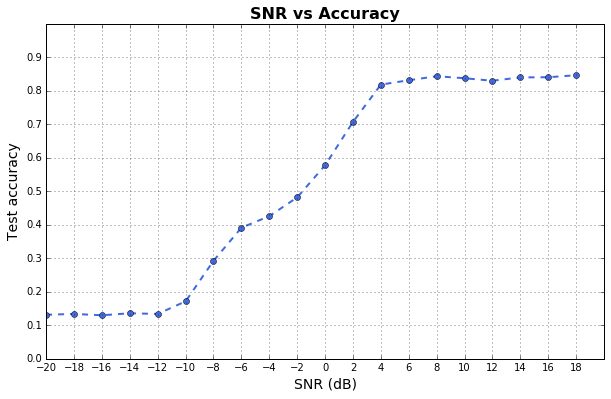

In [9]:
plt.style.use('classic')
%matplotlib inline

acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test_values = new_acc 

fig1 = plt.figure(figsize=(10, 6), dpi=100)
x = snrs
y = list(acc_test_values)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

INFO:tensorflow:Restoring parameters from ./DNN4layer_regtech_dropout
Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.82  0.00   0.00  0.00  0.01   0.08   0.08  0.00
BPSK   0.00  0.97   0.00  0.00  0.01   0.00   0.01  0.00
CPFSK  0.01  0.00   0.97  0.00  0.00   0.01   0.01  0.00
GFSK   0.01  0.00   0.00  0.97  0.00   0.01   0.01  0.00
PAM4   0.00  0.00   0.00  0.00  0.99   0.01   0.00  0.00
QAM16  0.07  0.00   0.00  0.00  0.00   0.54   0.39  0.00
QAM64  0.01  0.00   0.00  0.00  0.00   0.47   0.52  0.00
QPSK   0.03  0.00   0.00  0.00  0.00   0.05   0.03  0.89


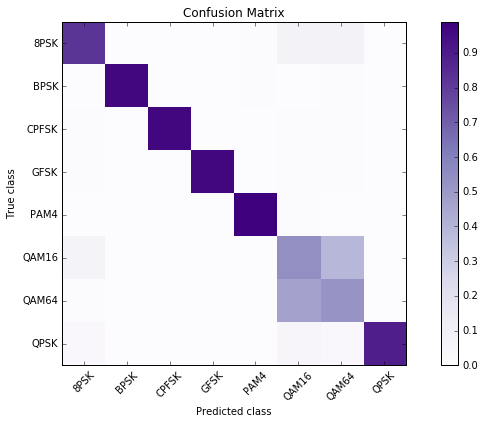

In [10]:
# Confusion Matrix

with tf.Session() as sess:
    saver.restore(sess, path)
    Z = logits.eval(feed_dict = {X : X_32test_std[18]})
    predicted_18dB = np.argmax(Z, axis = 1)
    
from sklearn.metrics import confusion_matrix
%matplotlib inline

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
conf_matrix = confusion_matrix(predicted_18dB, y_32_test[18])  

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

import pandas as pd

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()